# Visualization of Substance Abuse Treatment Center Admissions/Discharges

This program imports the Treatment Episode Data Set: Discharges (TEDS-D) from the Substance Abuse and Mental Health Data Archive (SAMHDA): a collection of data about admissions to and discharges from American substance abuse treatment centers documetented in 2014 (the last year on record). The script then makes graphs to visualize various treatment measures collected. 

Not all treatment episodes were documented: only admissions/discharges to state-licensed or certified treatment centers are included, and some states only report publicly-funded treatment. 

In addition, data entries represent treatment episodes rather than individuals, which may therefore be represented more than once for different episodes, and there is no tracking of individuals within the data set.

For more information, see https://datafiles.samhsa.gov/study-series/treatment-episode-data-set-discharges-teds-d-nid13520.

In addition, the github repository containing this code includes a PDF "codebook" that is useful for interpreting the .csv file and data labels. 

NOTE: .csv file is 234.3 MB.

In [ ]:
# import necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3

from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

In [ ]:
# import the data from the SAMHDA website and save it as a pandas dataframe

url = 'https://samhda.s3-us-gov-west-1.amazonaws.com/s3fs-public/field-uploads-protected/studies/TEDS-D-2014/TEDS-D-2014-datasets/TEDS-D-2014-DS0001/TEDS-D-2014-DS0001-bundles-with-study-info/TEDS-D-2014-DS0001-bndl-data-tsv.zip'

resp = urlopen(url)
zipfile = ZipFile(BytesIO(resp.read())) # unzip the folder downloaded from SAMHDA
TEDSD = pd.read_csv(zipfile.open('TEDS-D-2014-DS0001-data/TEDS-D-2014-DS0001-data-excel.csv'))
    

In [ ]:
# store the data into a SQL database

connection = sqlite3.connect("SAMHDAvisualization.sqlite")  
cur = connection.cursor()  

cur.execute("DROP TABLE IF EXISTS TEDSD");
TEDSD.to_sql(name="TEDSD", con=connection) 

In [ ]:
# delete the TEDSD dataframe to free up memory

del(TEDSD)

## How many treatment episodes were documented in each state/territory?

The first graph will show how many episodes were documented in each US state/territory in 2014, grouped by general region.

In [ ]:
# create a dictionary for the numerical coding of states (obtained from the TEDS-D codebook)

State_dict = {1:"Alabama",2:"Alaska", 4:"Arizona", 5:"Arkansas", 6:"California", 8:"Colorado", 9:"Connecticut",
             10:"Delaware", 11: "District of Columbia", 12: "Florida", 15:"Hawaii", 16:"Idaho", 17:"Illinois",
             18:"Indiana", 19:"Iowa", 21:"Kentucky", 22:"Louisiana", 23:"Maine", 24:"Maryland", 25:"Massachusetts",
             26: "Michigan", 27:"Minnesota", 28:"Mississippi", 29:"Missouri", 30:"Montana", 31:"Nebraska", 
             32:"Nevada", 33:"New Hampshire", 34:"New Jersey", 35:"New Mexico", 36:"New York", 37:"North Carolina",
             38:"North Dakota", 39:"Ohio", 40:"Oklahoma", 41: "Oregon", 42: "Pennsylvania", 44:"Rhode Island", 
             45: "South Carolina", 46:"South Dakota", 47:"Tennessee", 48:"Texas", 49:"Utah", 50:"Vermont", 
             51:"Virginia", 53:"Washington", 54:"West Virginia", 55:"Wisconsin", 56: "Wyoming", 72:"Puerto Rico"}

In [ ]:
# fetch the data from sql database

cur.execute("SELECT REGION,STFIPS,COUNT(CASEID) from TEDSD group by REGION,STFIPS");
state_table_with_codes = cur.fetchall()

In [ ]:
# make region-to-color code dictionary

region_color = {0:'black', 1:'blue', 2:'red', 3:'green', 4:'cyan'}

In [ ]:
# make the plot with different colors for different country regions

colors = []
states = []
episodes = []

for entry in state_table_with_codes:
    colors.append(region_color[entry[0]])
    states.append(State_dict[entry[1]])
    episodes.append(entry[2])

plt.figure(figsize=(20,10))
plt.bar(states, episodes, color=colors)
plt.xticks(rotation=90, fontsize = 16);
plt.yticks(fontsize=16)
plt.title("2014 Substance Abuse Treatment Center Admissions in USA", fontsize = 32);
plt.xlabel("US state/territory", fontsize = 20)
plt.ylabel("Total admissions/year", fontsize = 20);
plt.ylim(0,350000)
plt.text(1.5, 300000, "Northeast", color='blue',fontsize=20);
plt.text(12, 300000, "Midwest", color='red', fontsize=20);
plt.text(25, 300000, "South", color='green', fontsize=20);
plt.text(39, 300000, "West", color='cyan', fontsize=20);
plt.show()

The figure that is produced should look like this:

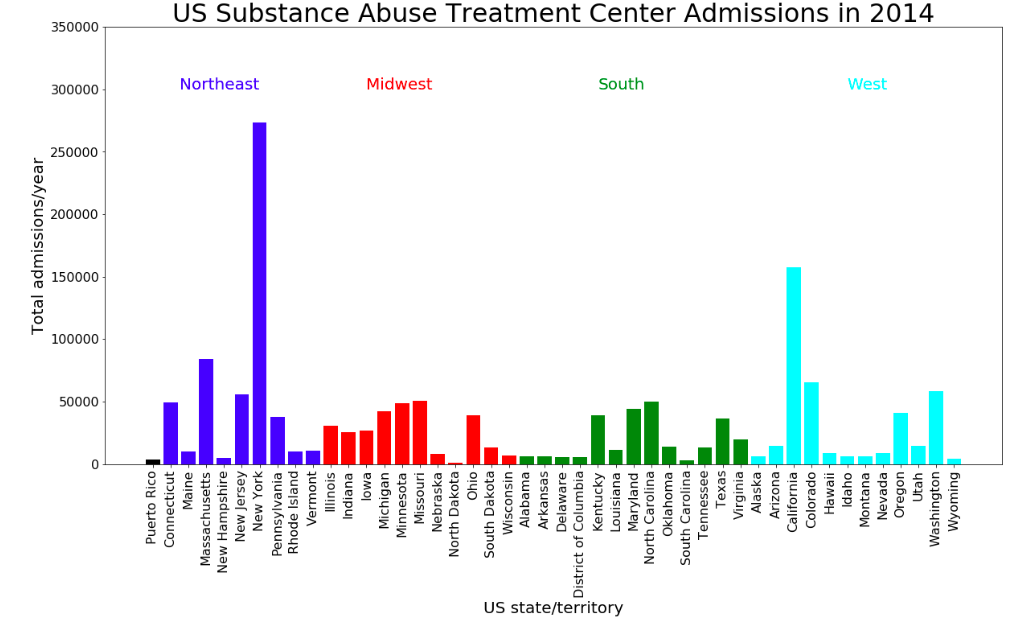
Notice that some states have many more admissions than others. This could be because of the difference in population size between states, as well as other factors such as reporting differences or accessibility of publicly-funded treatment centers. 

To look at this futher, we'll normalize the data by dividing by state population, and obtain the "per capita admissions" of each state. 

## What is the "per capita admissions" to treatment centers in each state?

In [ ]:
# retrieve US census state population estimates in 2014 as CSV data from my github repository
# then store the data as a pandas data frame 

url = 'https://github.com/katevitale/SAMHDA/archive/master.zip'
resp = urlopen(url)
zipfile = ZipFile(BytesIO(resp.read())) 
STATEPOPS = pd.read_csv(zipfile.open('SAMHDA-master/STATE POPULATIONS.csv'))

In [ ]:
# store the state population data in our SAMHDAvisualilzation database

cur.execute("DROP TABLE IF EXISTS STATEPOPS");# removes any pre-existing STATEPOPS tables
STATEPOPS.to_sql(name="STATEPOPS", con=connection) ;

In [ ]:
# fetch the state population data from the sql data and store it in a dictionary

cur.execute("SELECT STATE, POPULATION from STATEPOPS");
STATEPOPSlist = cur.fetchall()

STATEPOPSdict=dict()
for (state, pop) in STATEPOPSlist:
    STATEPOPSdict[state]=pop

In [ ]:
# plot the data with similar code as above

colors = []
states = []
per_capita_episodes = []

for entry in state_table_with_codes: 
    colors.append(region_color[entry[0]])
    states.append(State_dict[entry[1]])
    per_capita_episodes.append(entry[2]/STATEPOPSdict[State_dict[entry[1]]])

plt.figure(figsize=(20,10))
plt.bar(states, per_capita_episodes, color=colors)
plt.xticks(rotation=90, fontsize = 16);
plt.yticks(fontsize=16)
plt.title("2014 Per-Capita Substance Abuse Treatment Center Admissions in USA", fontsize =30);
plt.xlabel("US state/territory", fontsize = 20)
plt.ylabel("Admissions/person/year", fontsize = 20);
plt.ylim(0,0.025)
plt.text(1.5, 0.02, "Northeast", color='blue',fontsize=20);
plt.text(12, 0.02, "Midwest", color='red', fontsize=20);
plt.text(25, 0.02, "South", color='green', fontsize=20);
plt.text(39, 0.02, "West", color='cyan', fontsize=20);
plt.show()

The graph should look like this:

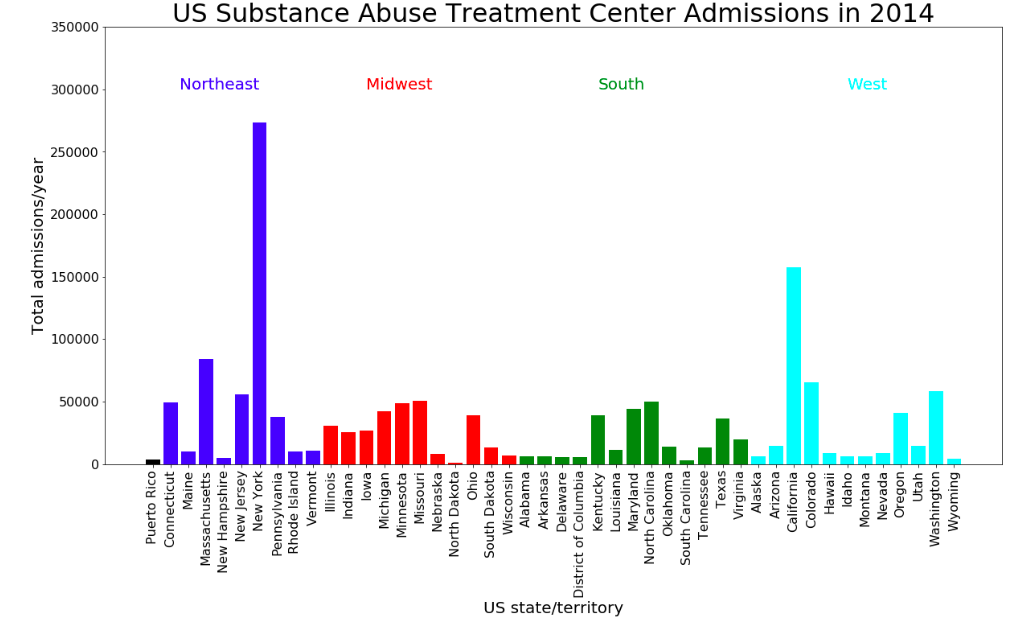

Treatment center admissions now appear to be somewhat more equally distributed across the states and territories, however there are still inequalities that may reflect reporting or access differences.

## What is the typical wait time for receiving substance abuse treatment?

The distribution of treatment wait times for could roughly indicate how accessible substance abuse treatment centers are across the US.

In [ ]:
# Fetch the counts of each length of wait time

cur.execute('SELECT DAYWAIT, COUNT(CASEID) from TEDSD group by DAYWAIT');
daywait_list = cur.fetchall();

In [ ]:
# make lists of waits and counts for plotting purposes

waits = []
counts = []

for item in daywait_list[1:len(daywait_list)]:
    waits.append(item[0])
    counts.append(item[1])

In [ ]:
# make a cumulative density plot of admission wait times  

plt.figure(figsize=(10,10))

cdf = np.cumsum (counts)
plt.plot(waits, cdf/cdf[-1]);
plt.xlim(0,100) # show only the first 100 days
plt.title("US Substance Abuse Treatment Center Admission Wait Times in 2014", fontsize=32);
plt.xlabel("Wait time (days)", fontsize=20)
plt.ylabel("Cumulative frequency", fontsize=20);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);

The graph should look like this:

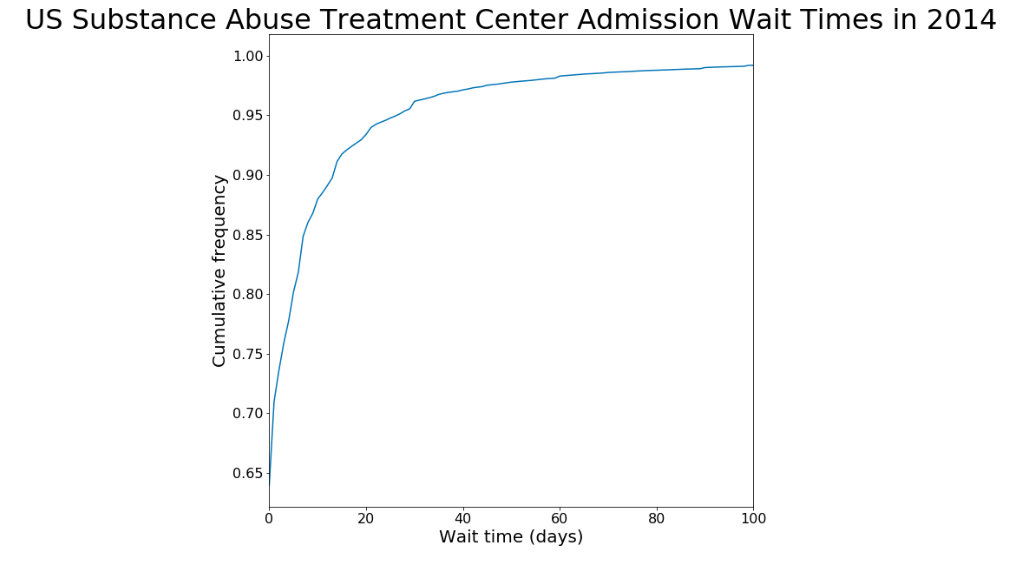

This data suggests that 65% of the times that people sought treatment for substance abuse, they were able to be admitted the same day. Within approximately a week, only 15% of individuals were still waiting for treatment. However, this last 15% of people took a long time to be admitted. This data is actually truncated, and there were wait times as long as several years recorded. Therefore, not all treatment-seeking people are able to obtain treatment in a timely manner.

## How many previous admissions to a treatment center did patients have when they were admitted?

How many times a patient was previously admitted to a treatment center gives some indication of the effectiveness of previous treatment. 

In [ ]:
# the counts of each number of prior admissions

cur.execute('SELECT NOPRIOR, COUNT(CASEID) from TEDSD group by NOPRIOR');
prior_list = cur.fetchall();

In [ ]:
# make lists of number of prior admissions and counts

priors = []
counts = []

for item in prior_list[1:len(prior_list)]:
    priors.append(str(item[0]))
    counts.append(item[1])
    
priors[len(priors)-1] = '5 or more'

In [ ]:
# make a bar plot showing the distribution of each number of previous admissions

plt.figure(figsize=(10,10))
plt.bar(priors, counts);

plt.title("Number of Prior Admissions Documented at Intake to US Substance Abuse Treatment Centers in 2014", fontsize=20);
plt.xlabel("Number of prior admissions", fontsize=20)
plt.ylabel("Count", fontsize=20);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);

The graph should look like this:

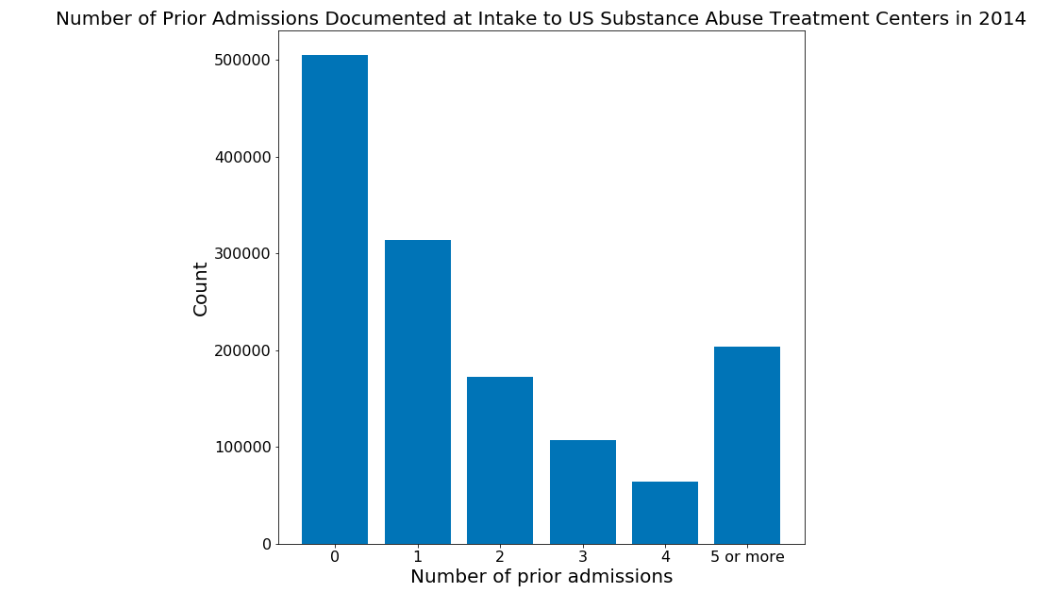

This graph suggests that about a third of admissions to treatment centers were for first-time treatment-seekers, but the rest had some prior history of admission to a treatment center. More than 10% of patients had 5 or more previous admissions to a treatment center. For these patients, treatment may not be effective in keeping their addiction in check.

## Why are patients discharged?

Do patients always successfully finish a treatment course, or are there other reasons they are discharged? The distribution of different reasons for discharge across all treatment episodes is given below.

In [ ]:
cur.execute('SELECT REASON, COUNT(CASEID) from TEDSD group by REASON');
reason_list = cur.fetchall();

counts = []

for item in reason_list:
    counts.append(item[1])

reason_name_list = ["Treatment completed",
                    "Left against professional advice",
                    "Terminated by facility",
                    "Transferred to another treatment center or facility",
                    "Incarcerated",
                    "Death",
                    "Other"]


plt.figure(figsize=(10,10))
plt.pie(counts, labels=reason_name_list, textprops={'fontsize': 16});

plt.title("Reasons for Discharge from US Substance Abuse Treatment Centers in 2014", fontsize=20);

The graph should look like:

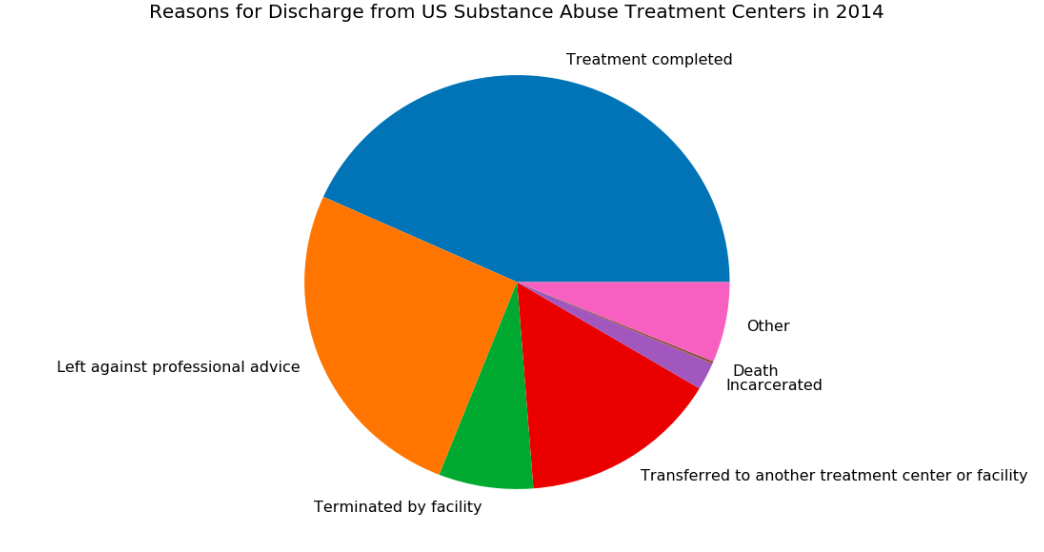

This graph shows that many people are discharged for reasons other than successfully completing treatment or being transferred to another treatment center. This includes leaving a program against professional advice or being removed from the program by a facility due to rule infraction, etc. 

## What is the distribution of lengths of stay in a treatment center?

In [ ]:
# make a graph of length of stay
cur.execute('SELECT LOS, COUNT(CASEID) from TEDSD group by LOS');
los_list = cur.fetchall();

lengths = []
counts = []
sum_counts = 0

for item in los_list[1:len(los_list)]:
    lengths.append(str(item[0]))
    counts.append(item[1])
    sum_counts += int(item[1])

# replace last length labels with ranges
last_bins = ['31-45', '46-60', '61-90', '91-120', '121-180', '181-365', '>365']

lengths[30:len(lengths)] = last_bins
  
norm_counts = []    
for count in counts:
    norm_counts.append(count/sum_counts)
plt.figure(figsize=(20,10))
plt.bar(lengths, counts)  
plt.title("Length of stay at US Substance Abuse Treatment Centers in 2014", fontsize=32);
plt.xlabel("Length of stay (days)", fontsize=20)
plt.ylabel("Count", fontsize=20);
plt.xticks(fontsize=16, rotation=90);
plt.yticks(fontsize=16);

The graph should look like:

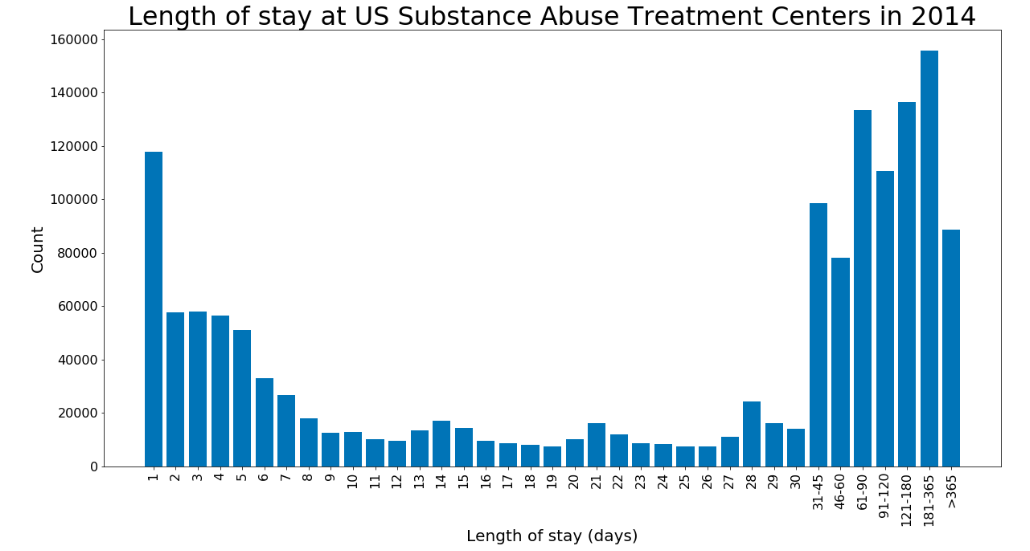

It appears to be a roughly exponential distribution of lengths of stay, since the last bins are ranges of several days (this is how data was stored). There is a huge spike of lengths of stay of only one day. Are these all people that left treatment against professional advice? The graph below looks at that next.

## What are the reasons for discharge at each length of stay?

In [ ]:
# make a stacked bar graph with the reasons for leaving

df = pd.read_sql("""SELECT LOS, 
                 sum((REASON=1)*1) AS "Treatment completed", 
                 sum((REASON=2)*1) AS "Left against professional advice", 
                 sum((REASON=3)*1) AS "Terminated by facility",
                 sum((REASON=4)*1) AS "Transferred to another treatment center or facility",
                 sum((REASON=5)*1) AS "Incarcerated",
                 sum((REASON=6)*1) AS "Death",
                 sum((REASON=7)*1) AS "Other"

                from TEDSD group by LOS""", con=connection)

df = df.drop([0], axis=0)
df = df.drop('LOS', axis=1)

df = df.rename(index=dict(zip(np.arange(1,len(lengths)+1),lengths)))

df.plot.bar(stacked="True", figsize=(20,10));

plt.xticks(fontsize=16);
plt.yticks(fontsize=16)
plt.title("Substance Abuse Treatment Center Discharges in 2014", fontsize=32);
plt.ylabel("Count", fontsize=20);
plt.xlabel("Length of stay (days)", fontsize=20)
plt.legend(title="Reason for discharge");

The graph should look like:

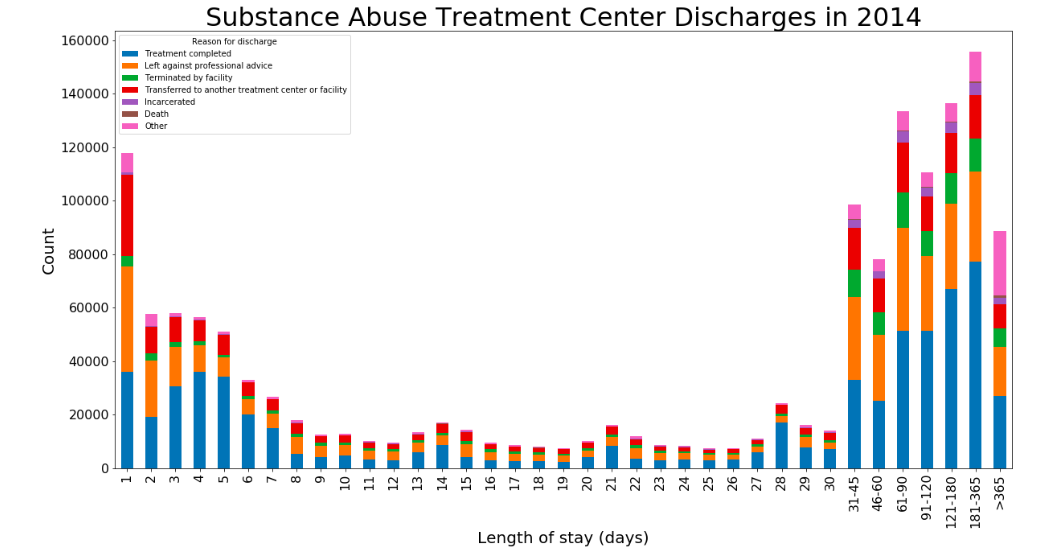

Surprisingly, a similar fraction of discharges are categorized as patients leaving against professional advice across all lengths of stay. Even more surprisingly, a substantial proportion of discharges that occured after a short treatment period of a week or even a day or two are listed as successful treatment completion. This raises further questions about this data set and treatment standards.  